In [1]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')




In [2]:
# Connecting to Google Drive and mount project to running instance

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Need to manually set project path.
fpath='/content/drive/MyDrive/Colab Notebooks/Capstone'

print(f"Project filepath, fpath: {fpath}")

#
file_path_censo = fpath+'/data/Comercial_Censo.csv'
file_path_metero = fpath+'/data/Comercial_Meteorología.csv'
file_path_test = fpath+'/data/Comercial_Test.csv'
file_path_ventas = fpath+'/data/Comercial_Ventas.csv'
file_path_ventas_test = fpath+'/data/Comercial_Test.csv'

data_censo = pd.read_csv(file_path_censo, delimiter=';', encoding='latin1', decimal=',',thousands='.')
data_meteoro = pd.read_csv(file_path_metero, delimiter=',', decimal=',', encoding='latin1',usecols=lambda column: column not in ['Unnamed: 0'])
data_test= pd.read_csv(file_path_test, delimiter=';', encoding='latin1')
data_ventas= pd.read_csv(file_path_ventas, delimiter=';', decimal=',', encoding='latin1')
data_ventas['sale_date']=pd.to_datetime(data_ventas['Dia'], dayfirst=True)

data_ventas_test=pd.read_csv(file_path_ventas_test, delimiter=';', decimal=',', encoding='latin1')
data_ventas_test['sale_date']=pd.to_datetime(data_ventas_test['Dia']) # not the same date format as Comercial_Ventas.csv!


Project filepath, fpath: /content/drive/MyDrive/Colab Notebooks/Capstone


In [4]:
# Two lines with missing location data
pd.concat((data_ventas.loc[data_ventas.Longitud.isnull()],data_ventas.loc[data_ventas.Latitud.isnull()]))

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta,sale_date
219,19/04/2016,GOA,43.31749,NaN,1.044,0.485941,ES4,19,abril,2016,Martes,NaN,2016-04-19
702,17/12/2016,95,NaN,-8.479238,1.269,0.217169,ES4,17,diciembre,2016,Sabado,NaN,2016-12-17


In [5]:
# can use the non-missing coordinate to lookup the missing coordinate (each latitude and longitude are unique)
station_loc=data_ventas.groupby('Longitud').Latitud.agg(lambda x: x.mode().sort_values()[0]).to_frame().reset_index()
station_loc[['Latitud','Longitud']]

,Latitud,Longitud
0,43.275401,-8.529408
1,43.274713,-8.528744
2,43.317490,-8.479238
3,43.373076,-8.427898
4,43.333647,-8.402475
5,43.338868,-8.393727
6,43.311974,-8.365214
7,43.346004,-8.268857
8,43.502874,-8.221867
9,43.341288,-8.203681


In [6]:
# Station names have 2 typos in the
print("Train data:",data_ventas.Nombre.value_counts())
print("\nTest data:",data_ventas_test.Nombre.value_counts())

Train data: Nombre
ES2     2192
ES6     2192
ES1     2192
ES9     2192
ES5     2192
ES11    2192
ES12    2192
ES8     2192
ES3     2192
ES10    2192
ES4     2191
ES7     2191
ES40       1
ES70       1
Name: count, dtype: int64

Test data: Nombre
ES4     62
ES2     62
ES6     62
ES1     62
ES9     62
ES5     62
ES11    62
ES12    62
ES8     62
ES3     62
ES10    62
ES7     62
Name: count, dtype: int64


In [7]:
# Station names are wrong extra 0, Latitud,Longitud same as for ES4 and ES7
data_ventas.loc[data_ventas.Nombre.isin(['ES40','ES70'])]
data_ventas.loc[data_ventas.Nombre=='ES40','Nombre']='ES4'
data_ventas.loc[data_ventas.Nombre=='ES70','Nombre']='ES7'

In [8]:
stations=data_ventas.groupby('Nombre')[['Latitud','Longitud']].agg(lambda x: x.mode().sort_values()[0]).reset_index()
stations['Number']=stations.Nombre.apply(lambda x: int(x[-1]) if len(x)<4 else int(x[-2:]))
stations.sort_values(by='Number')

stations.to_pickle(fpath+'/data/stations.pkl')

## Sales data (NVentas) cleaning

```
# This is formatted as code
```



In [9]:
# check Product data
data_ventas.Producto.value_counts()

Producto
GOA    13152
95     13150
98         2
Name: count, dtype: int64

In [10]:
# sale of 98 only happens on 2 days, looks like a typo?
data_ventas.loc[data_ventas.Producto=='98']

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta,sale_date
17478,03/12/2018,98,43.472243,-8.161883,1.259,0.317348,ES12,3,diciembre,2018,Lunes,NaN,2018-12-03
26212,16/11/2018,98,43.338868,-8.393727,1.319,0.263571,ES7,16,noviembre,2018,Viernes,NaN,2018-11-16


In [11]:
# no sale of 95 so assume 98 is a typo
data_ventas.loc[(data_ventas.Nombre=="ES7") & (data_ventas.Dia=="16/11/2018"),:]

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta,sale_date
26212,16/11/2018,98,43.338868,-8.393727,1.319,0.263571,ES7,16,noviembre,2018,Viernes,NaN,2018-11-16
26213,16/11/2018,GOA,43.338868,-8.393727,1.289,0.616068,ES7,16,noviembre,2018,Viernes,NaN,2018-11-16


In [12]:
# fix typos
data_ventas.loc[data_ventas.Producto=="98","Producto"]="95"

In [13]:
# One day appears to have a factor 1000 error and 2 are >1 which is +1 error?
data_ventas.sort_values(by='VentasN',ascending=False).head(10)

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta,sale_date
25968,17/07/2018,95,43.338868,-8.393727,1.359,211.984676,ES7,17,julio,2018,Martes,NaN,2018-07-17
26037,20/08/2018,GOA,43.338868,-8.393727,1.279,2.000000,ES7,20,agosto,2018,Lunes,NaN,2018-08-20
26126,04/10/2018,95,43.338868,-8.393727,1.399,1.160000,ES7,4,octubre,2018,Jueves,NaN,2018-10-04
13569,27/07/2016,GOA,43.341288,-8.203681,1.049,1.000000,ES11,27,julio,2016,Miercoles,NaN,2016-07-27
23,12/01/2016,GOA,43.317490,-8.479238,0.989,1.000000,ES4,12,enero,2016,Martes,NaN,2016-01-12
16437,30/06/2017,GOA,43.472243,-8.161883,1.089,1.000000,ES12,30,junio,2017,Viernes,NaN,2017-06-30
18005,22/08/2016,GOA,43.274713,-8.528744,1.099,1.000000,ES8,22,agosto,2016,Lunes,NaN,2016-08-22
7529,21/04/2017,GOA,43.114013,-8.147955,1.169,1.000000,ES1,21,abril,2017,Viernes,NaN,2017-04-21
2219,14/01/2016,GOA,43.502874,-8.221867,0.979,1.000000,ES2,14,enero,2016,Jueves,NaN,2016-01-14
24293,31/03/2016,GOA,43.338868,-8.393727,NaN,1.000000,ES7,31,marzo,2016,Jueves,NaN,2016-03-31


In [14]:
# fix x1000 error
data_ventas.loc[data_ventas.VentasN>5,'VentasN']=data_ventas.loc[data_ventas.VentasN>5,'VentasN']/1000
# fix +1 error see below
p1filt=(data_ventas.VentasN>1)
data_ventas.loc[p1filt,"VentasN"]=data_ventas.loc[p1filt,'VentasN']-1


### Price (PVP) cleaning

In [15]:
# look for errors in pricing (2 found look like x100 and x10 error)
data_ventas.sort_values(by='PVP',ascending=False).head(5)

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Day,Month,Year,Weekday,Fiesta,sale_date
25288,11/08/2017,95,43.338868,-8.393727,124.900,0.282160,ES7,11,agosto,2017,Viernes,NaN,2017-08-11
15480,09/03/2016,95,43.472243,-8.161883,11.490,0.160718,ES12,9,marzo,2016,Miercoles,NaN,2016-03-09
6408,09/10/2018,95,43.346004,-8.268857,1.429,0.382895,ES6,9,octubre,2018,Martes,NaN,2018-10-09
6400,05/10/2018,95,43.346004,-8.268857,1.429,0.359917,ES6,5,octubre,2018,Viernes,NaN,2018-10-05
6412,11/10/2018,95,43.346004,-8.268857,1.429,0.265373,ES6,11,octubre,2018,Jueves,NaN,2018-10-11


In [16]:
# fix for price x100 error for 95 in ES7 on 2017-08-11
filtfix=(data_ventas.sale_date=="2017-08-11")&(data_ventas.Producto=="95")&(data_ventas.Nombre=="ES7")&(data_ventas.PVP>50)
data_ventas.loc[filtfix,"PVP"]=data_ventas.loc[filtfix,"PVP"]/100
# fix for price x10 error for 95 in ES12 on 2016-03-09    11.490
filtfix=(data_ventas.sale_date=="2016-03-09")&(data_ventas.Producto=="95")&(data_ventas.Nombre=="ES12")&(data_ventas.PVP>10)
data_ventas.loc[filtfix,"PVP"]=data_ventas.loc[filtfix,"PVP"]/10



<Axes: title={'center': 'Missing PVP for GOA'}, xlabel='sale_date'>

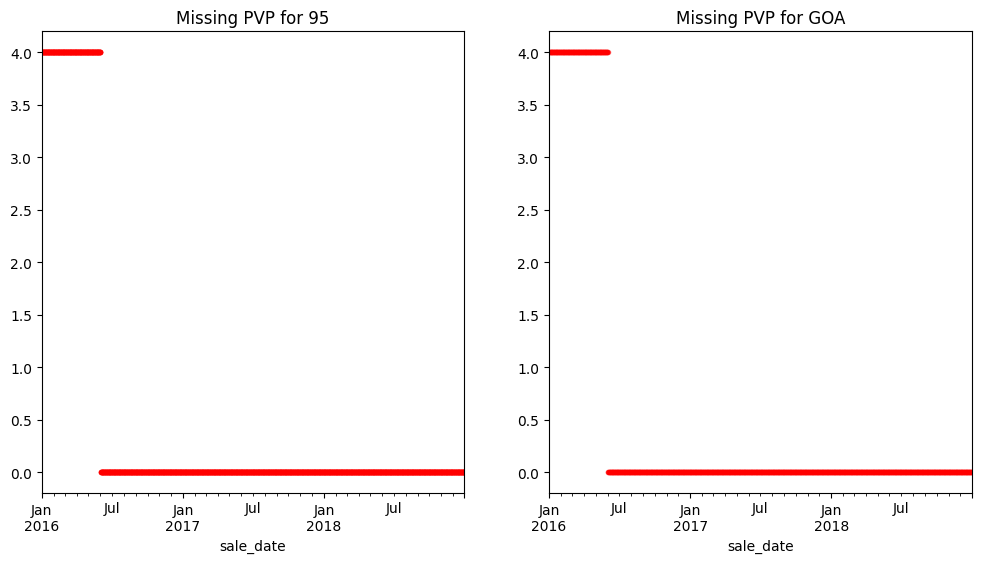

In [17]:
# missing prices at 4 stations first 6 mths of 2016 and a couple of days late in 2018
fig,ax=plt.subplots(1,2,figsize=(12,6))
data_ventas.groupby(['sale_date','Nombre','Producto']).PVP.first().unstack().unstack()["95"].isna().sum(axis=1).plot(c='r',ls='',marker='.',ax=ax[0],title='Missing PVP for 95')
data_ventas.groupby(['sale_date','Nombre','Producto']).PVP.first().unstack().unstack()["GOA"].isna().sum(axis=1).plot(c='r',ls='',marker='.',alpha=0.5,ax=ax[1],title='Missing PVP for GOA')


In [18]:
# flat version of pvp data
df_flat_pvp=pd.merge(data_ventas.groupby(['sale_date','Nombre','Producto']).PVP.first().unstack().unstack()["95"],data_ventas.groupby(['sale_date','Nombre','Producto']).PVP.first().unstack().unstack()["GOA"],how='inner',left_index=True,right_index=True,suffixes=('_95','_GOA'))

# Fill missing PVP values with median values of the same product on the same day
for i,r in df_flat_pvp.iterrows():
    for c in df_flat_pvp.columns:
        if np.isnan(r[c]):
            #print(i,end=',')
            #print([cc for cc in df_flat_pvp.columns if (c.split('_')[1] in cc)])
            df_flat_pvp.loc[i,c]=r[[cc for cc in df_flat_pvp.columns if (c.split('_')[1] in cc)]].median()

df_flat_pvp['MED_95']=df_flat_pvp.loc[:,df_flat_pvp.columns.str.contains('95')].median(axis=1)
df_flat_pvp['MED_GOA']=df_flat_pvp.loc[:,df_flat_pvp.columns.str.contains('GOA')].median(axis=1)

df_flat_pvp_test=pd.merge(data_ventas_test.groupby(['sale_date','Nombre','Producto']).PVP.first().unstack().unstack()["95"],data_ventas_test.groupby(['sale_date','Nombre','Producto']).PVP.first().unstack().unstack()["GOA"],how='inner',left_index=True,right_index=True,suffixes=('_95','_GOA'))

# save price data to file
df_flat_pvp.to_pickle(fpath+'/data/df_flat_pvp.pkl')
df_flat_pvp_test.to_pickle(fpath+'/data/df_flat_pvp_test.pkl')



Text(0.5, 1.0, 'Diesel sales')

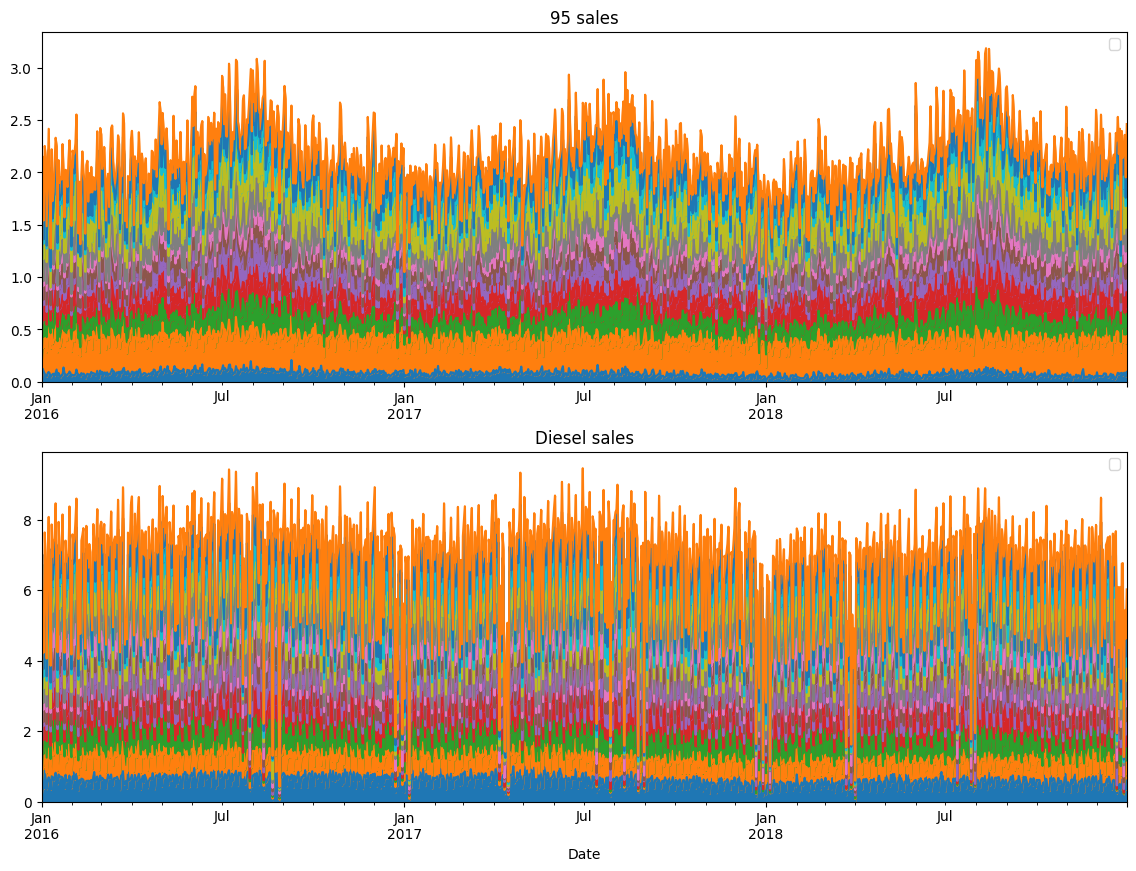

In [19]:
fig,ax=plt.subplots(2,1,figsize=(14,10))
df_95=data_ventas.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["95"]
df_GOA=data_ventas.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["GOA"]
df_95.plot.area(stacked=True,ax=ax[0])
df_GOA.plot.area(stacked=True,ax=ax[1])
ax[0].legend([])
ax[1].legend([])
ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_title('95 sales')
ax[1].set_title('Diesel sales')

# 95 more seasonal sales (up in jul-sep), but diesel is down XMAS/EOY and jul-sep (also Eastern 2017 and 2028 but not 2016?)

Text(0.5, 1.0, 'Diesel sales')

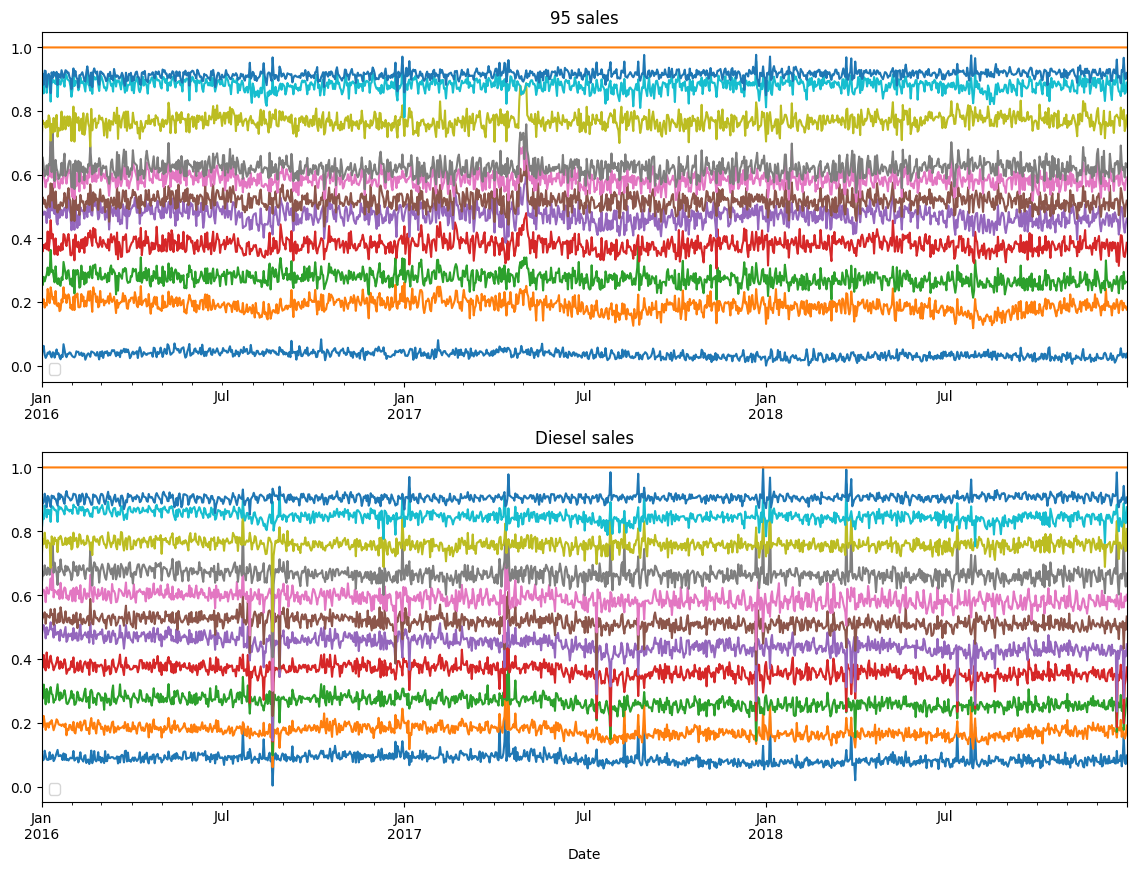

In [20]:
total95=df_95.sum(axis=1)
totalGOA=df_GOA.sum(axis=1)

stacked=True
fig,ax=plt.subplots(2,1,figsize=(14,10))
data_ventas.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["95"].div(total95,axis=0).plot(stacked=stacked,ax=ax[0])
data_ventas.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["GOA"].div(totalGOA,axis=0).plot(stacked=stacked,ax=ax[1])
ax[0].legend([])
ax[1].legend([])
ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_title('95 sales')
ax[1].set_title('Diesel sales')

# Diesel sales have more extreme values that occur around XMAS/EOY and Aug-Sep?

### Extract holidays from sales data

In [21]:
#  Look at holidays
fiestas=data_ventas.groupby('sale_date').Fiesta.max()
df_total=total95.to_frame().rename(columns={0:"95"})
df_total['GOA']=totalGOA
df_total['Fiesta']=fiestas
df_total.Fiesta.value_counts()
# holidays seem important

Fiesta
Jueves Santo                       6
Epifanía del Señor                 3
Martes de Carnaval                 3
San José                           3
Viernes Santo                      3
Día de las Letras Gallegas         3
Asunción de la Virgen              3
Fiesta Nacional de España          3
Día de todos Los Santos            3
Día de la Constitución Española    3
La Inmaculada Concepción           3
Año Nuevo                          2
San Juan                           2
Fiesta del Trabajo                 2
Natividad del Señor                2
Name: count, dtype: int64

In [22]:


# Extract actual holidays from data_ventas (df_total)
df_p_holidays=df_total.loc[df_total.Fiesta.notna(),['Fiesta']].reset_index().rename(columns={"sale_date":"ds","Fiesta":"holiday"})
# Add holidays in test period
df_p_holidays=pd.concat([df_p_holidays,pd.DataFrame({'ds':[datetime.datetime(2019,1,1),datetime.datetime(2019,1,6)],'holiday':['Año Nuevo','Epifanía del Señor']})],ignore_index=True)

# store in data folder for later use
df_p_holidays.to_pickle(fpath+'/data/df_p_holidays.pkl')



In [23]:


df_flat=pd.merge(data_ventas.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["95"],data_ventas.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["GOA"],how='left',left_index=True,right_index=True,suffixes=('_95','_GOA'))
df_flat['ALL_95']=df_flat.loc[:,df_flat.columns.str.contains('95')].sum(axis=1)
df_flat['ALL_GOA']=df_flat.loc[:,df_flat.columns.str.contains('GOA')].sum(axis=1)

df_flat_test=pd.merge(data_ventas_test.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["95"],data_ventas_test.groupby(['sale_date','Nombre','Producto']).VentasN.sum().unstack().unstack()["GOA"],how='left',left_index=True,right_index=True,suffixes=('_95','_GOA'))
df_flat_test['ALL_95']=df_flat_test.loc[:,df_flat_test.columns.str.contains('95')].sum(axis=1)
df_flat_test['ALL_GOA']=df_flat_test.loc[:,df_flat_test.columns.str.contains('GOA')].sum(axis=1)


df_flat.to_pickle(fpath+'/data/df_flat.pkl')
df_flat_test.to_pickle(fpath+'/data/df_flat_test.pkl')
